In [ ]:
!kaggle datasets download prishasawhney/imdb-dataset-top-2000-movies

Dataset URL: https://www.kaggle.com/datasets/prishasawhney/imdb-dataset-top-2000-movies
License(s): other
100% 75.5k/75.5k [00:00<00:00, 698kB/s]
100% 75.5k/75.5k [00:00<00:00, 696kB/s]


In [ ]:

!unzip imdb-dataset-top-2000-movies.zip


Archive:  imdb-dataset-top-2000-movies.zip
  inflating: imdb_top_2000_movies.csv  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
data = pd.read_csv("/content/imdb_top_2000_movies.csv")

In [ ]:
print(data.head(5))

              Movie Name Release Year  Duration  IMDB Rating  Metascore  \
0          The Godfather         1972       175          9.2      100.0   
1  The Godfather Part II         1974       202          9.0       90.0   
2        Ordinary People         1980       124          7.7       86.0   
3     Lawrence of Arabia         1962       218          8.3      100.0   
4             Straw Dogs         1971       113          7.4       73.0   

       Votes                        Genre              Director  \
0  2,002,655                 Crime, Drama  Francis Ford Coppola   
1  1,358,608                 Crime, Drama  Francis Ford Coppola   
2     56,476                        Drama        Robert Redford   
3    313,044  Adventure, Biography, Drama            David Lean   
4     64,331       Crime, Drama, Thriller         Sam Peckinpah   

                Cast     Gross  
0      Marlon Brando  $134.97M  
1          Al Pacino   $57.30M  
2  Donald Sutherland   $54.80M  
3      Peter O

In [ ]:
data.columns

Index(['Movie Name', 'Release Year', 'Duration', 'IMDB Rating', 'Metascore',
       'Votes', 'Genre', 'Director', 'Cast', 'Gross'],
      dtype='object')

In [ ]:
# prompt: def clean_votes and return only numeric values

def clean_votes(votes):
    # Remove commas and convert to numeric, handling non-numeric values
    cleaned_votes = []
    for vote in votes:
        try:
            cleaned_votes.append(int(str(vote).replace(',', '')))
        except ValueError:
            cleaned_votes.append(np.nan)  # Or any other appropriate default value
    return cleaned_votes


In [ ]:

for col in ['IMDB Rating', 'Metascore']:
    data[col] = pd.to_numeric(data[col], errors='coerce') # Convert to numeric, coercing errors to NaN
    mean_value = data[col].mean()
    data[col].fillna(mean_value, inplace=True)


<ipython-input-43-db59cec2a383>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mean_value, inplace=True)


In [ ]:
def clean_year(year_str):
    """Extract and clean 4-digit year from string input."""
    try:
        # Convert to string and clean special characters
        text = str(year_str).strip()

        # Extract all 4-digit numbers that could be years (1800-2100)
        matches = re.findall(r'\b(18|19|20)\d{2}\b', text)

        if matches:
            # Take the first valid year found
            return float(matches[0])

        # If no 4-digit year found but it's a clean number, verify it's a valid year
        if text.isdigit() and 1800 <= int(text) <= 2100:
            return float(text)

        # If conversion fails, return default
        return 1980.0
    except:
        return 1980.0  # Default value

def clean_gross(gross_str):
    """Clean gross revenue data by handling currency format."""
    try:
        if pd.isna(gross_str):
            return 0.0
        if isinstance(gross_str, (int, float)):
            return float(gross_str)

        # Remove '$' and 'M', convert to float
        cleaned = gross_str.replace('$', '').replace('M', '')
        return float(cleaned)
    except:
        return 0.0

def create_preprocessor(df):
    """Create a preprocessing pipeline for the data."""
    # Create feature columns
    numeric_features = ['Release Year', 'Duration', 'Votes', 'Gross']
    categorical_features = ['Genre', 'Director', 'Cast']

    # Create preprocessor
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

def preprocess_data(df):
    """Clean and preprocess the data."""
    df = df.copy()
    df['Release Year'] = df['Release Year'].apply(clean_year)
    df['Gross'] = df['Gross'].apply(clean_gross)
    df['Votes'] = clean_votes(df['Votes'])
    return df

In [64]:
class MovieRecommender:
    def __init__(self):
        self.model = None
        self.preprocessor = None
        self.target_scaler = None

    def train(self, data):
        # Preprocess the data
        global X_test, y_test
        data = preprocess_data(data)

        # Prepare features and targets
        X = data[['Release Year', 'Duration', 'Votes', 'Gross', 'Genre', 'Director', 'Cast']]
        y = data[['IMDB Rating', 'Metascore']]

        # Scale targets
        self.target_scaler = StandardScaler()
        y_scaled = self.target_scaler.fit_transform(y)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_scaled, test_size=0.2, random_state=42
        )

        # Create and train pipeline
        self.preprocessor = create_preprocessor(X)
        self.model = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', LinearRegression())
        ])

        # Fit the model
        self.model.fit(X_train, y_train)

        # Calculate and print metrics
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Model Performance:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R² Score: {r2:.4f}")

        return self.model


    def evaluate_and_visualize(self, X_test, y_test):
      """Evaluates the model and creates visualizations."""
      # Predicting using the trained model
      y_pred = self.model.predict(X_test)

      # Rescaling the predictions back to original values if necessary
      y_pred = self.target_scaler.inverse_transform(y_pred)
      y_test = self.target_scaler.inverse_transform(y_test)

      # Calculate evaluation metrics
      mse = mean_squared_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)

      print(f"Mean Squared Error: {mse:.4f}")
      print(f"R² Score: {r2:.4f}")

      # --- 1. Scatter Plot for IMDB Ratings ---
      plt.figure(figsize=(8, 6))
      sns.scatterplot(x=y_test[:, 0], y=y_pred[:, 0], label='IMDB Rating')
      plt.plot([y_test[:, 0].min(), y_test[:, 0].max()],
              [y_test[:, 0].min(), y_test[:, 0].max()],
              color='red', linestyle='--', label='Perfect Prediction')
      plt.xlabel('Actual IMDB Rating')
      plt.ylabel('Predicted IMDB Rating')
      plt.title('Actual vs. Predicted IMDB Ratings')
      plt.legend()
      plt.show()

      # --- 2. Scatter Plot for Metascore ---
      plt.figure(figsize=(8, 6))
      sns.scatterplot(x=y_test[:, 1], y=y_pred[:, 1], label='Metascore')
      plt.plot([y_test[:, 1].min(), y_test[:, 1].max()],
              [y_test[:, 1].min(), y_test[:, 1].max()],
              color='red', linestyle='--', label='Perfect Prediction')
      plt.xlabel('Actual Metascore')
      plt.ylabel('Predicted Metascore')
      plt.title('Actual vs. Predicted Metascores')
      plt.legend()
      plt.show()

      # --- 3. Bar Graph: Actual vs Predicted IMDB Ratings ---
      plt.figure(figsize=(10, 6))
      indices = np.arange(len(y_test))
      width = 0.35
      fig, ax = plt.subplots()
      ax.bar(indices - width / 2, y_test[:, 0], width, label='Actual IMDB Rating')
      ax.bar(indices + width / 2, y_pred[:, 0], width, label='Predicted IMDB Rating')
      ax.set_xlabel('Movies')
      ax.set_ylabel('IMDB Ratings')
      ax.set_title('Actual vs Predicted IMDB Ratings')
      ax.legend()
      plt.show()

      # --- 4. Box Plot for IMDB Ratings Distribution ---
      plt.figure(figsize=(8, 6))
      sns.boxplot(data=[y_test[:, 0], y_pred[:, 0]], notch=True)
      plt.xticks([0, 1], ['Actual IMDB Rating', 'Predicted IMDB Rating'])
      plt.ylabel('IMDB Ratings')
      plt.title('Box Plot: Actual vs Predicted IMDB Ratings')
      plt.show()

      # --- 5. Box Plot for Metascore Distribution ---
      plt.figure(figsize=(8, 6))
      sns.boxplot(data=[y_test[:, 1], y_pred[:, 1]], notch=True)
      plt.xticks([0, 1], ['Actual Metascore', 'Predicted Metascore'])
      plt.ylabel('Metascore')
      plt.title('Box Plot: Actual vs Predicted Metascore')
      plt.show()

      # --- 6. Count Plot of Predictions (Optional) ---
      plt.figure(figsize=(8, 6))
      sns.countplot(x=np.round(y_pred[:, 0]), label='Predicted IMDB Rating')
      plt.xlabel('Predicted IMDB Rating')
      plt.title('Count of Predicted IMDB Ratings')
      plt.show()

      # --- 7. Heatmap of Correlations (Actual vs Predicted) ---
      plt.figure(figsize=(8, 6))
      actual_vs_predicted = np.concatenate((y_test, y_pred), axis=1)
      corr_matrix = np.corrcoef(actual_vs_predicted.T)
      sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                  xticklabels=['Actual IMDB', 'Actual Metascore', 'Predicted IMDB', 'Predicted Metascore'],
                  yticklabels=['Actual IMDB', 'Actual Metascore', 'Predicted IMDB', 'Predicted Metascore'])
      plt.title('Heatmap: Correlation between Actual and Predicted Ratings')
      plt.show()

    def recommend_movies(self, data, n_recommendations=5):
        # Preprocess the data
        data = preprocess_data(data)

        # Make predictions for all movies
        X = data[['Release Year', 'Duration', 'Votes', 'Gross', 'Genre', 'Director', 'Cast']]
        predictions = self.model.predict(X)

        # Scale back predictions
        predictions_original = self.target_scaler.inverse_transform(predictions)

        # Calculate average predicted rating (combining IMDB and Metascore)
        # Normalize Metascore to 0-10 scale to match IMDB
        avg_ratings = (predictions_original[:, 0] + (predictions_original[:, 1] / 10)) / 2

        # Get top N recommendations
        top_indices = np.argsort(avg_ratings)[-n_recommendations:][::-1]

        recommendations = []
        for idx in top_indices:
            recommendations.append({
                'Movie Name': data.iloc[idx]['Movie Name'],
                'Predicted IMDB Rating': predictions_original[idx][0],
                'Predicted Metascore': predictions_original[idx][1],
                'Average Normalized Rating': avg_ratings[idx]
            })

        return recommendations


In [65]:
recommender = MovieRecommender()
recommender.train(data)

    # Get recommendations

recommendations = recommender.recommend_movies(data, n_recommendations=3)

print("\nTop 3 Movie Recommendations:")
for i, rec in enumerate(recommendations, 1):
  print(f"\n{i}. {rec['Movie Name']}")
  print(f"   Predicted IMDB Rating: {rec['Predicted IMDB Rating']:.1f}")
  print(f"   Predicted Metascore: {rec['Predicted Metascore']:.1f}")
  print(f"   Average Normalized Rating: {rec['Average Normalized Rating']:.2f}")



Model Performance:
Mean Squared Error: 1.5164
R² Score: -0.4182

Top 3 Movie Recommendations:

1. Star Wars
   Predicted IMDB Rating: 11.2
   Predicted Metascore: 108.3
   Average Normalized Rating: 11.03

2. Cloverfield
   Predicted IMDB Rating: 11.6
   Predicted Metascore: 103.9
   Average Normalized Rating: 10.99

3. Blade Runner
   Predicted IMDB Rating: 9.6
   Predicted Metascore: 118.2
   Average Normalized Rating: 10.69


Mean Squared Error: 240.3265
R² Score: -0.4182


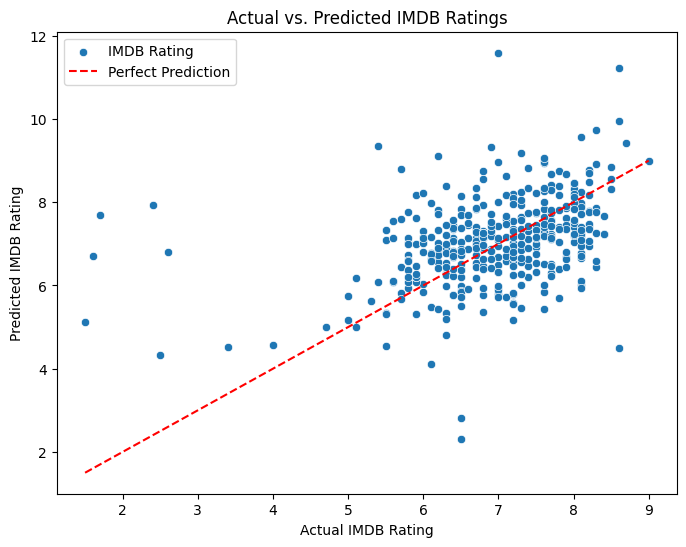

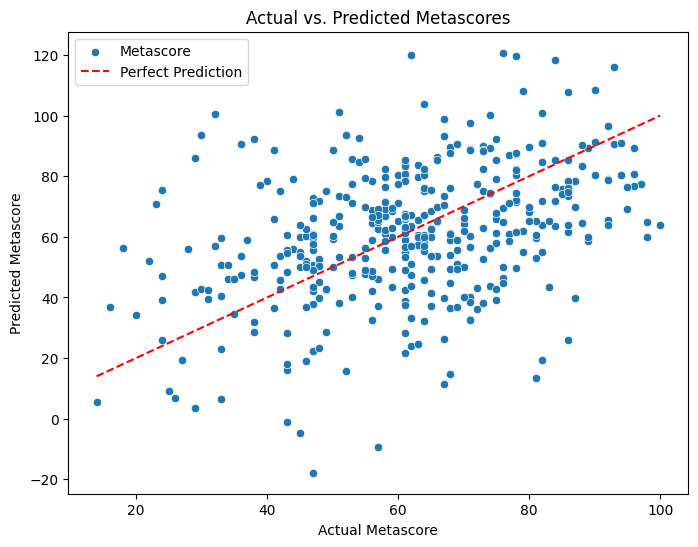

<Figure size 1000x600 with 0 Axes>

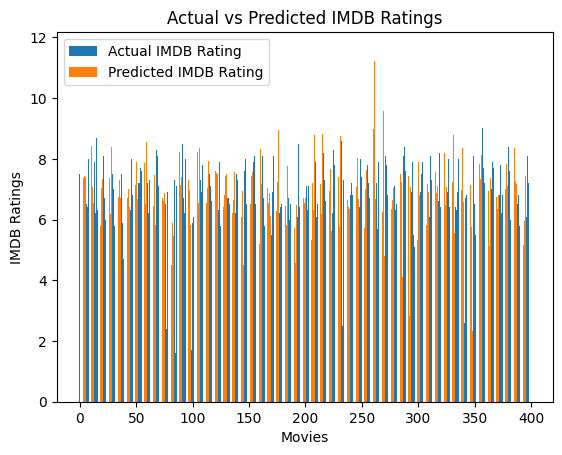

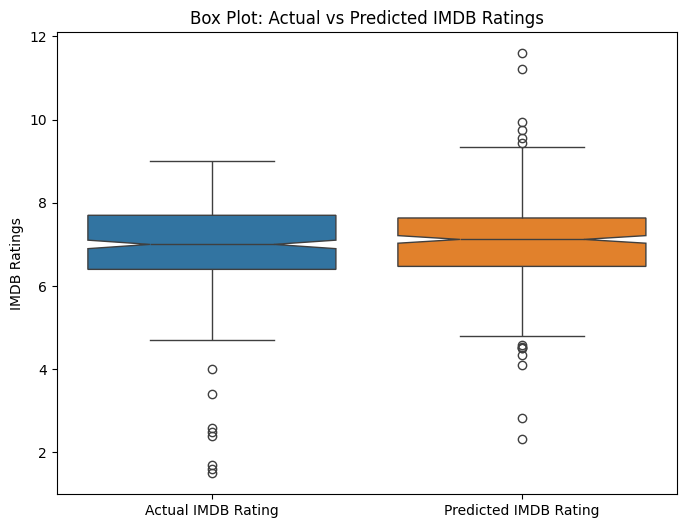

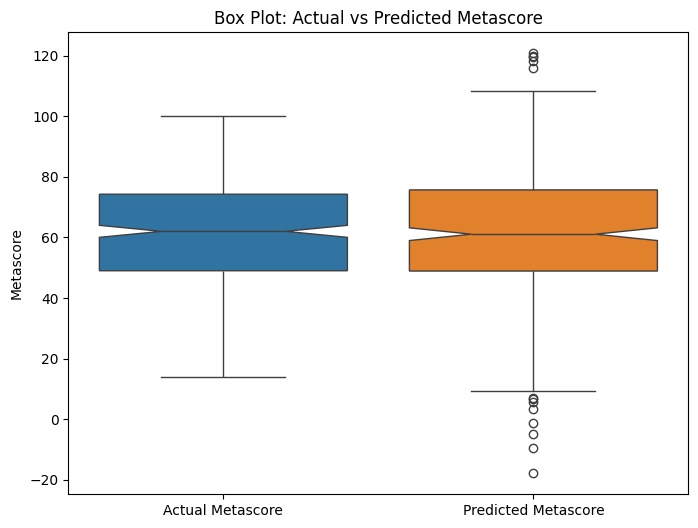

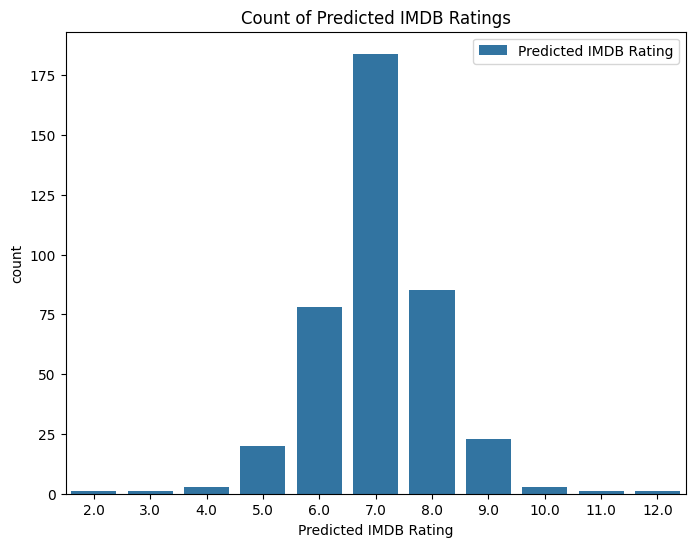

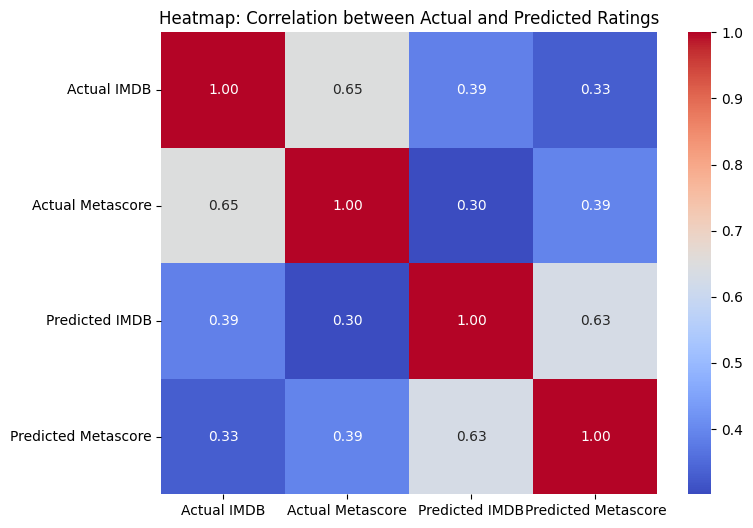

In [66]:
recommender.evaluate_and_visualize(X_test, y_test)